## Global variables

In [1]:
redo_training = False

#path to pickle file
path_all_data = 'pickle_files/titanic_all_data_2020-01-07_12-27.pickle'
path_trees_estimators = 'pickle_files/titanic_trees_estimators_2020-01-08_13-00.pickle'

## Importing librairies

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

import sklearn, pickle, datetime
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif,f_classif

# Dataset description

In [4]:
titanic = pd.read_csv('titanic_dataset/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


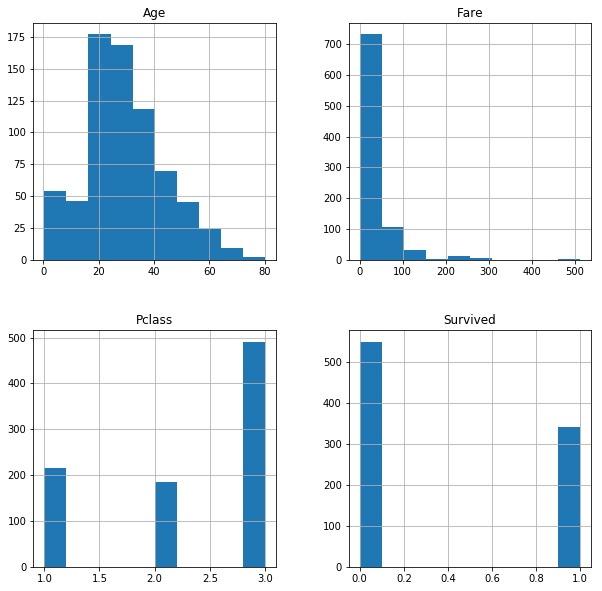

In [6]:
hist = titanic.hist(column=['Age','Survived','Fare','Pclass'],layout=(2,2),figsize=(10,10))

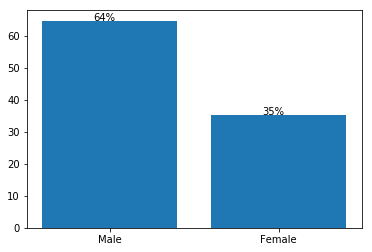

In [7]:
sex_count = titanic.Sex.value_counts()
sex_count = (sex_count/len(titanic))*100
plot = plt.bar(x =['Male','Female'],height = sex_count, label=['Female','Male'])

for i in plot.patches:
    plt.text(x =i.get_x()+0.3,y=i.get_height(),s = "{}{}".format(int(i.get_height()),'%'))

In [8]:
print("Percentage of values per feature:\n")
counts = titanic.count()
for col,t in zip(counts.index,counts):
    perc = (t/len(titanic))*100
    print(col,': ',round(perc,2),'%')

Percentage of values per feature:

PassengerId :  100.0 %
Survived :  100.0 %
Pclass :  100.0 %
Name :  100.0 %
Sex :  100.0 %
Age :  80.13 %
SibSp :  100.0 %
Parch :  100.0 %
Ticket :  100.0 %
Fare :  100.0 %
Cabin :  22.9 %
Embarked :  99.78 %


In [9]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Dataset preprocessing

In [10]:
titanic_int = titanic[['Pclass','Age','SibSp','Parch','Fare','Cabin']]
survived = titanic['Survived']

In [11]:
#Binarizing Sex feature
lb = preprocessing.LabelBinarizer()
lb = lb.fit_transform(titanic['Sex'])
titanic_int['Sex'] = lb

#Categorizing Embarked feature
titanic_int['Embarked'] = pd.Categorical(pd.factorize(titanic.Embarked)[0])#nan values in embarked are labelized as -1
titanic_int.head()

C:\Users\ppike\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ppike\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex,Embarked
0,3,22.0,1,0,7.2500,NaN,1,0
1,1,38.0,1,0,71.2833,C85,0,1
2,3,26.0,0,0,7.9250,NaN,0,0
3,1,35.0,1,0,53.1000,C123,0,0
4,3,35.0,0,0,8.0500,NaN,1,0


In [12]:
#Replacing Nan values by mean for Age feature
nan = titanic_int.isna()

nan_age = nan[nan.Age == True]
titanic_int.loc[nan_age.index,'Age']  = np.mean(titanic_int['Age'])

#Setting Cabin feature to binary
nan_cabin = nan[nan.Cabin == True]
titanic_int['Cabin'] = 1
titanic_int.loc[nan_cabin.index,'Cabin'] = 0

titanic_int.head()

C:\Users\ppike\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ppike\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex,Embarked
0,3,22.0,1,0,7.2500,0,1,0
1,1,38.0,1,0,71.2833,1,0,1
2,3,26.0,0,0,7.9250,0,0,0
3,1,35.0,1,0,53.1000,1,0,0
4,3,35.0,0,0,8.0500,0,1,0


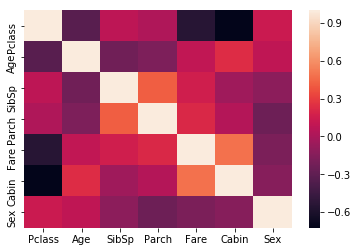

In [13]:
corr_m = titanic_int.corr()
sns.heatmap(corr_m)

With this correlation matrix we can sse that:
- feature Parch and SibSp are correlated, it seems coherent because people how had siblings aboard were likely to have their parents with them or people how came with their spouses were likely to have children
- feature Cabin and Fare are correlated, it seems coherent that if you had a Cabin your ticket would be most expensive
- feature Cabin is anti-correlated with Pclass, it seems that only the highest class had cabins

In [14]:
survived = np.array(survived)
titanic_arr = np.array(titanic_int)

#Developp on choosing the right scaler
titanic_arr = preprocessing.scale(titanic_arr)

# Model selection

In [15]:
from sklearn.experimental import enable_hist_gradient_boosting 

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import tree

import sklearn.metrics as metrics

In [16]:
X = titanic_arr
y = survived
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

In [17]:
names = ['knc','svc','dtc','rfc','mlpc','abc','gnb','qda','sgdc','bc','etc','gbc','hgbc']

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    #GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(n_estimators=10),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier()]

parameters = [
    {'weights':('uniform','distance'),'algorithm':('ball_tree','kd_tree','brute'),'leaf_size':range(10,51)},
    {'kernel':('linear','poly','rbf','sigmoid'),'degree':range(1,6),'decision_function_shape':('ovo','ovr')},
    {'criterion':('gini','entropy'),'splitter':('best','random'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'activation':('identity','logistic','tanh','relu'),'solver':('lbfgs','sgd','adam'),\
              'learning_rate':('constant','invscaling','adaptive')},
    {'n_estimators':range(40,60),'algorithm':('SAMME','SAMME.R'),'learning_rate':np.arange(0.1,1.1,0.1)},
    {'var_smoothing': np.arange(1e-9,10e-7,1e-8)},
    {'store_covariance':(True,False),'tol': np.arange(1e-4,1.0,1e-4)},
    {'loss':('hinge','log','modified_huber','squared_hinge','perceptron','squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'),\
             'penalty':('none','l2','l1','elasticnet'),'fit_intercept':(True,False),'shuffle':(True,False)},
    {'n_estimators':range(5,15),'bootstrap_features':(True,False),'oob_score':(True,False)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),'min_samples_leaf':range(1,10)},
    {'loss':('deviance','exponential'),'learning_rate':np.arange(0.1,1.1,0.1),'criterion':('friedman_mse','mse','mae'),'max_features':('auto','sqrt','log2')},
    {'loss':('auto','binary_crossentropy','categorical_crossentropy'),'learning_rate':np.arange(0.1,1.1,0.1)}
]

best_estimators = []
all_data = []


In [18]:
if redo_training == True:
    for clf,param,name in zip(classifiers,parameters,names):
        clf = GridSearchCV(clf,param,cv=5,verbose=1,n_jobs=-1)
        clf.fit(X_train,y_train)
        best_estimators.append((name,clf.best_estimator_))
        all_data.append(clf)
        print(name, clf.best_score_)
        
    #Saving the data to a pickle file to avoid recomputing
    date = datetime.datetime.now()
    date = date.strftime('%Y-%m-%d_%H-%M')

    pickle.dump(all_data,open('pickle_files/titanic_all_data_'+date+'.pickle','wb'))
    print('all_data was saved in pickle_files/titanic_all_data_'+date+'.pickle')
else:
    all_data = pickle.load(open(path_all_data,'rb'))

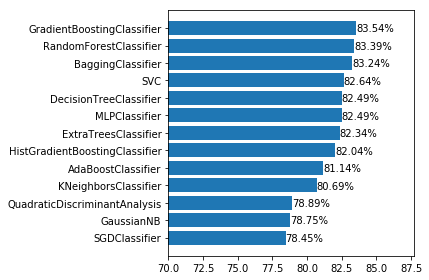

In [19]:
scores = []
names = []

for clf in all_data:
    scores.append(clf.best_score_)
    names.append(str(clf.best_estimator_).split('(')[0])

best_estimators = pd.DataFrame()
best_estimators['Name']=names
best_estimators['Score']=pd.Series(scores) *100
best_estimators.sort_values(by='Score',inplace=True)

plot = plt.barh(y = np.arange(len(names)), width = best_estimators['Score'], tick_label = best_estimators['Name'])
plt.axis(xmin = 70.0)
plt.tight_layout()

for i in plot.patches:
    plt.text(y=i.get_y()+0.2,x=i.get_width(),s='{}%'.format(round(i.get_width(),2)))


In [20]:
estimators = []

for data,name in zip(all_data,names):
    estimators.append((name,data.best_estimator_))

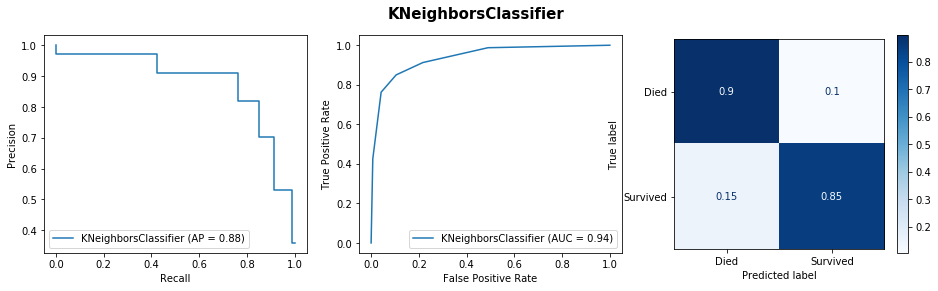

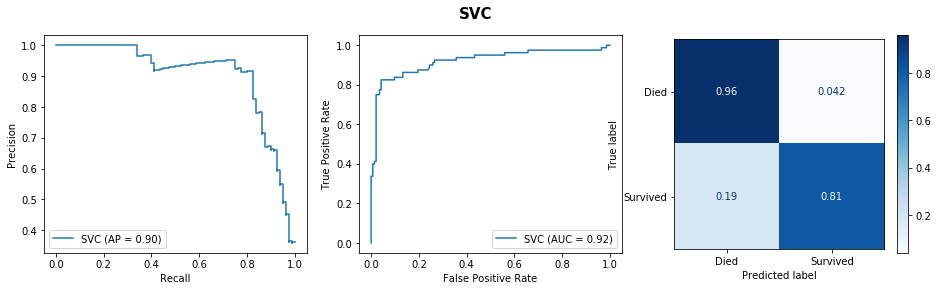

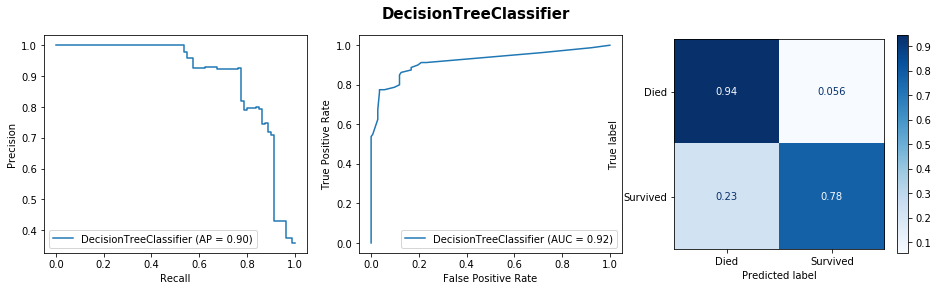

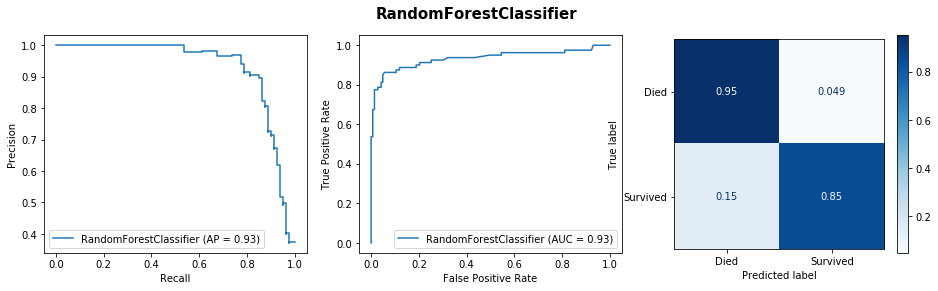

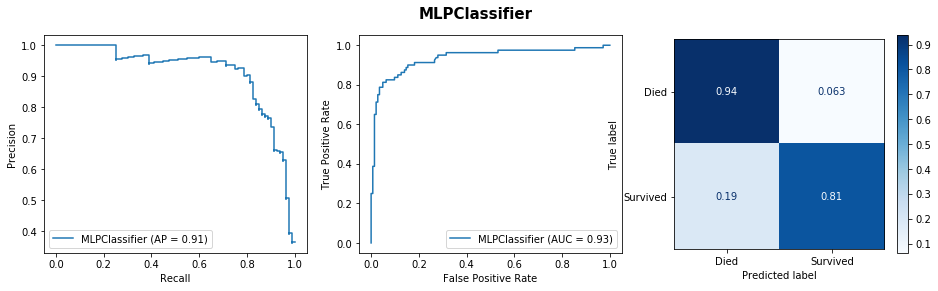

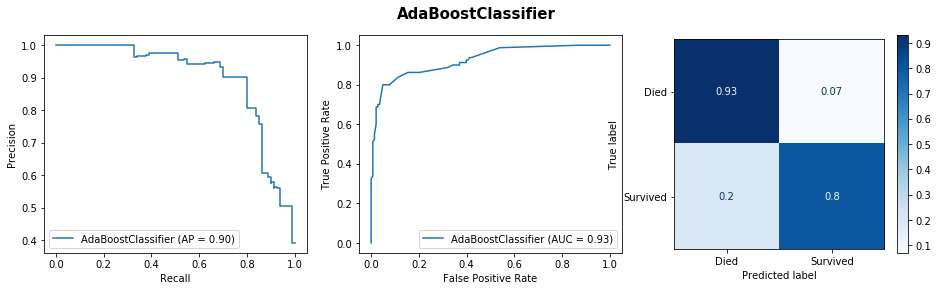

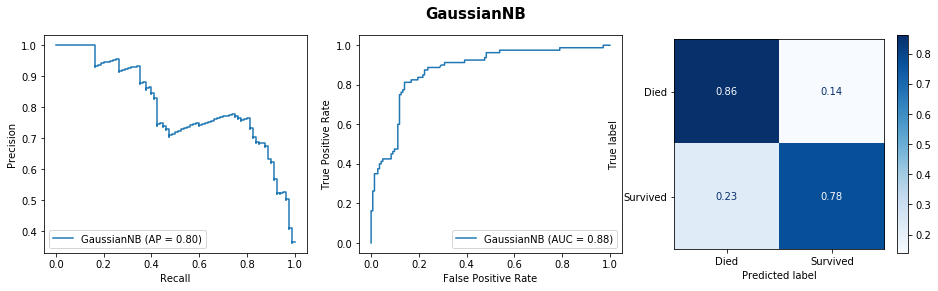

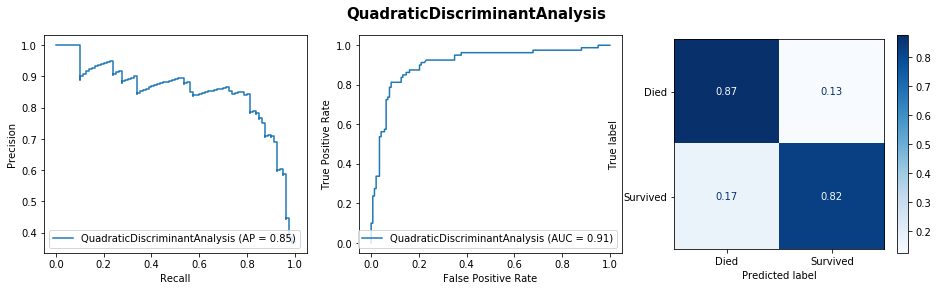

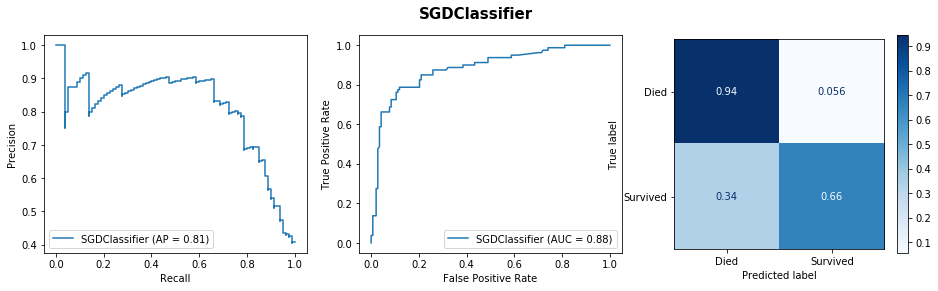

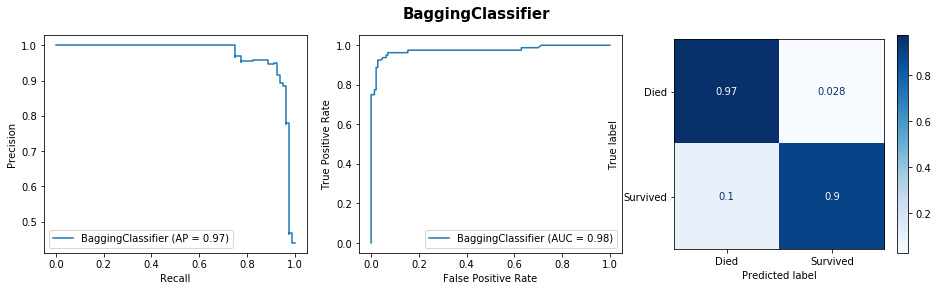

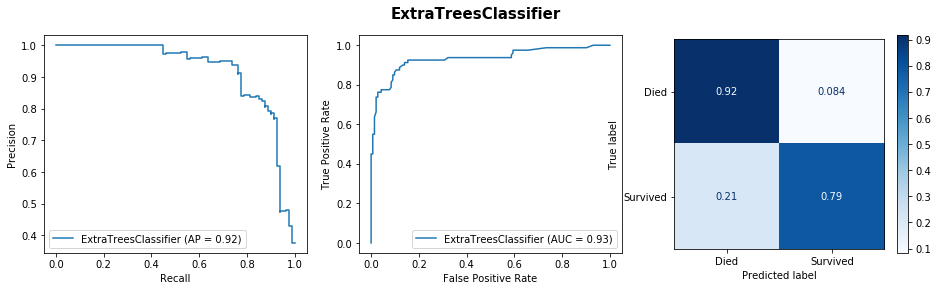

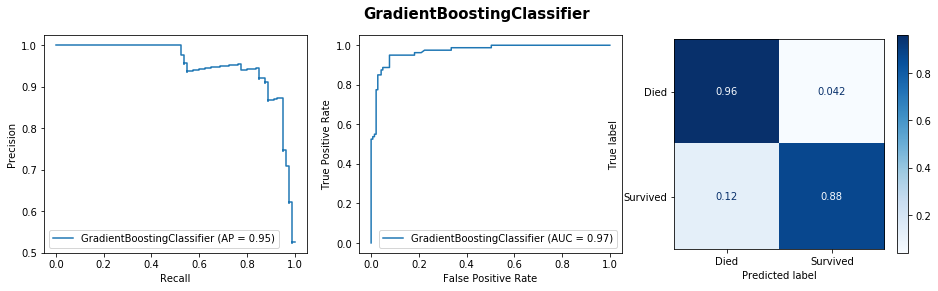

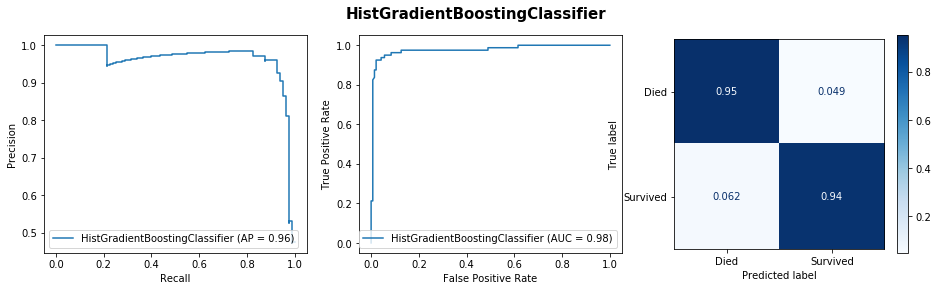

In [21]:
for clf in estimators:
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
    
    fig.suptitle(clf[0],fontsize=15,fontweight='bold')
    clf = clf[1]
    
    metrics.plot_precision_recall_curve(clf,X_test,y_test,ax=ax1)    
    metrics.plot_roc_curve(clf,X_test,y_test,ax=ax2)
    metrics.plot_confusion_matrix(clf,X_test,y_test,cmap=plt.cm.Blues,normalize='true',display_labels=['Died','Survived'],ax=ax3)

## Voting classifier

C:\Users\ppike\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy_score 0.8789237668161435
balanced_accuracy_score 0.8678055990262563
average_precision_score 0.7555271826385429


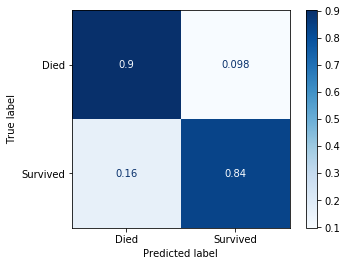

In [26]:
voting_clf = VotingClassifier(estimators)
voting_clf.fit(X_train,y_train)
predictions = voting_clf.predict(X_test)

print('accuracy_score',metrics.accuracy_score(predictions,y_test))
print('balanced_accuracy_score',metrics.balanced_accuracy_score(predictions,y_test))
print('average_precision_score',metrics.average_precision_score(predictions,y_test))

metrics.plot_confusion_matrix(voting_clf,X_test,y_test,cmap=plt.cm.Blues,normalize='true',display_labels=['Died','Survived'])


# Focusing on trees

In [23]:
names = ['dtc','rfc','etc']

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    ExtraTreesClassifier(n_estimators=10)]

parameters = [
    {'criterion':('gini','entropy'),'splitter':('best','random'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),'min_samples_leaf':range(1,10)}
]

best_trees_estimators = []

In [24]:
if redo_training == True:
    for clf,param,name in zip(classifiers,parameters,names):
        #print(clf,param)
        clf = GridSearchCV(clf,param,cv=5,verbose=1,n_jobs=-1)
        clf.fit(X_train,y_train)
        best_trees_estimators.append((name,clf.best_estimator_))
        print(name, clf.best_score_)
        
    #Saving the data to a pickle file to avoid recomputing
    date = datetime.datetime.now()
    date = date.strftime('%Y-%m-%d_%H-%M')

    pickle.dump(best_trees_estimators,open('pickle_files/titanic_trees_estimators_'+date+'.pickle','wb'))
    print('best_trees_estimators was saved in pickle_files/titanic_trees_estimators_'+date+'.pickle')
else:
    best_trees_estimators = pickle.load(open(path_trees_estimators,'rb'))

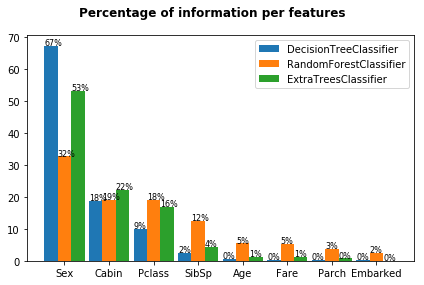

In [25]:
fig,axis = plt.subplots()
fig.suptitle('Percentage of information per features',fontweight='bold')


x = np.arange(len(titanic_int.columns)*3,step =3)  # the label locations
width = 0.9  # the width of the bars

n = 0 
axis.set_xticks(x)


for clf in best_trees_estimators:
    coord = x + n*width
    n = n+1
    
    feature_importance = pd.DataFrame(index=titanic_int.columns)
    name = str(clf[1]).split('(')[0]
    names.append(name)
    
    clf = clf[1]
    clf = clf.fit(X_train,y_train)
    
    feature_importance['Percentage']= clf.feature_importances_ * 100
    feature_importance.sort_values(by='Percentage',inplace=True,ascending=False)
    
    axis.bar(x = coord,tick_label=feature_importance.index,height=feature_importance['Percentage'],width=width,label=name)

    
for i in axis.patches:
    axis.text(x = i.get_x(),y = i.get_height()+0.2,s = "{}{}".format(int(i.get_height()),'%'),fontsize=8)
    

plt.xticks(x+width)
axis.legend()

plt.tight_layout(rect=[0, 0, 1,0.93])

We can notice that for the DecisionTreeClassifier and the ExtraTreesClassifier the Sex features brings more than half of the information. The information on the RandomForestClassifier is spread on more features.